In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb
from preprocessing import*
from model.convolutional_neural_network import *
from model.Executor import *
import warnings  
warnings.filterwarnings("ignore")

import torch.nn.functional as functional


# Training Data

The statistics on the size of our dataset.

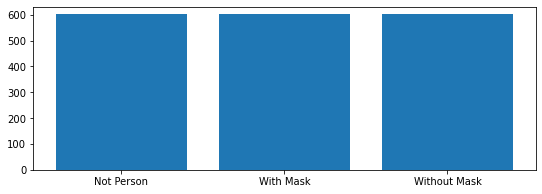

In [4]:
names = ['Not Person', 'With Mask', 'Without Mask']
N = []
N.append(len(os.listdir("./dataset/NotPerson")))
N.append(len(os.listdir("./dataset/WithMask")))
N.append(len(os.listdir("./dataset/WithoutMask")))
plt.figure(figsize=(9, 3))
plt.bar(names, N)
plt.show()

Create datasets for training and testing the model.

In [5]:
dataset = load_data("./dataset")
tr_ds, te_ds = split_data(dataset)
tr_loader = train_dataloarder(tr_ds)
te_loader = test_dataloarder(te_ds)

# Deep Learning

Implementing and training the CNN model.

In [6]:
num_epochs = 20
exec_obj = Executor()
all_loss,iter_loss,accuracy = exec_obj.training_model_executor(
    tr_loader,
    num_epochs
)


  0/20... rate=0 Hz, eta=?, total=0:00:00, wall=15:47 EST
current iter acc: 82.2963
current iter loss: 79.5053
  1/20... rate=0.03 Hz, eta=0:10:50, total=0:00:34, wall=15:47 EST
current iter acc: 84.7407
current iter loss: 69.2750
  2/20... rate=0.03 Hz, eta=0:08:50, total=0:00:58, wall=15:48 EST
current iter acc: 83.7037
current iter loss: 62.6592
  3/20... rate=0.04 Hz, eta=0:07:54, total=0:01:23, wall=15:48 EST
current iter acc: 86.3704
current iter loss: 58.3248
  4/20... rate=0.04 Hz, eta=0:07:12, total=0:01:48, wall=15:48 EST
current iter acc: 89.5556
current iter loss: 54.3980
  5/20... rate=0.04 Hz, eta=0:06:39, total=0:02:13, wall=15:49 EST
current iter acc: 92.3704
current iter loss: 50.9456
  6/20... rate=0.04 Hz, eta=0:06:12, total=0:02:39, wall=15:49 EST
current iter acc: 84.0741
current iter loss: 48.3132
  7/20... rate=0.04 Hz, eta=0:05:43, total=0:03:04, wall=15:50 EST
current iter acc: 92.5926
current iter loss: 45.8743
  8/20... rate=0.04 Hz, eta=0:05:14, total=0:03:2

In [7]:
testdata_accuracy = exec_obj.calculate_model_accuracy(te_loader)
print("Model accuracy for test dataset :",testdata_accuracy)
print(len(te_ds))

Model accuracy for test dataset : 96.0
450


# Evaluation

Confusion matrix.

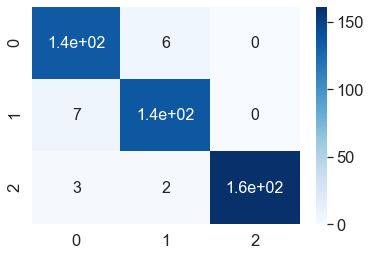

In [8]:
calc_model_weights, actual_results = next(iter(te_loader))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

Creating a table of results in order to show the accuracy, precision, recall and f1-score.

In [9]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       0.93      0.96      0.94       141
without mask       0.94      0.95      0.95       143
not a person       1.00      0.97      0.98       166

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



# Saving the trained model.

In [10]:
save_path = os.path.join(os.path.abspath("."), "trained_model.pt")
torch.save(exec_obj.network.state_dict(), save_path)

exec_obj = Executor()

model = convolutional_neural_network.convolutional_neural_network()

model.load_state_dict(torch.load(save_path))

exec_obj.network = model

In [11]:
dataset_female = load_data("./biasTestData/Female")
dataset_male = load_data("./biasTestData/Male")
dataset_all = load_data("./biasTestData/All")

te_loader_female = test_dataloarder(dataset_female)
te_loader_male = test_dataloarder(dataset_male)
te_loader_all = test_dataloarder(dataset_all)

print("Model accuracy for test dataset(Female):", exec_obj.calculate_model_accuracy(te_loader_female))
print("Model accuracy for test dataset(Male):", exec_obj.calculate_model_accuracy(te_loader_male))
print("Model accuracy for test dataset(All):", exec_obj.calculate_model_accuracy(te_loader_all))



Model accuracy for test dataset(Female): 97.5
Model accuracy for test dataset(Male): 98.75
Model accuracy for test dataset(All): 97.94117647058823
